In [94]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import plot_param_importances, plot_optimization_history
import optuna

In [70]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [71]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [72]:
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True) 

In [73]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [74]:
#Transform the variable into a numerical one.
def map_age(age):
    if age == '<1H OCEAN':
        return 0
    elif age == 'INLAND':
        return 1
    elif age == 'NEAR OCEAN':
        return 2
    elif age == 'NEAR BAY':
        return 3
    elif age == 'ISLAND':
        return 4
df['ocean_proximity'] = df['ocean_proximity'].apply(map_age)

In [75]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1


In [31]:
# save new preprocessed df
df.to_csv('preprocessed_housing.csv', index=False)

In [76]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['median_house_value'])
y = df.median_house_value

X_train, X_val, y_train, y_val = train_test_split(X, y,  test_size=0.2, random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16512, 9), (4128, 9), (16512,), (4128,))

In [77]:
regressor = xgb.XGBRegressor(objective ='reg:squarederror', 
                 colsample_bytree = 1, 
                 eta=0.3, 
                 learning_rate = 0.01,
                 max_depth = 5, 
                 alpha = 10, 
                 n_estimators = 500)

regressor.fit(X_train, y_train) 

XGBRegressor(alpha=10, eta=0.3, learning_rate=0.01, max_depth=5,
             n_estimators=500, objective='reg:squarederror')

In [78]:
y_pred = regressor.predict(X_val)

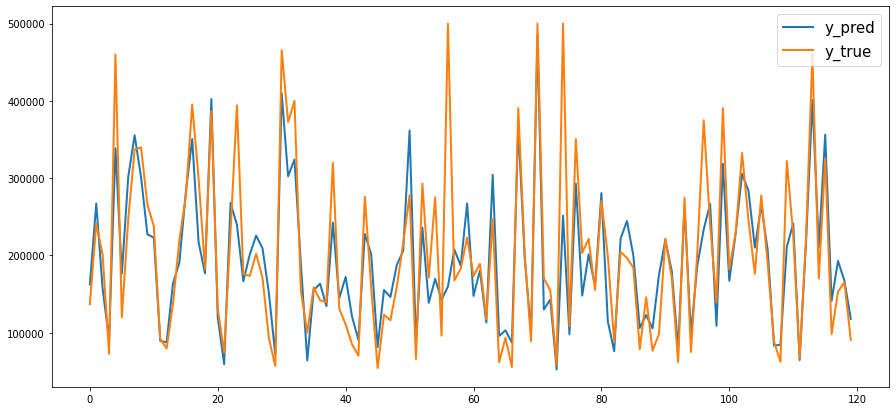

In [39]:
# plot the outputs

grp = pd.DataFrame({'y_pred': y_pred,'y_true' : y_val})
grp = grp.reset_index()
grp = grp.drop(['index'], axis=1)
plt.figure(figsize=(15, 7))
plt.plot(grp[:120],linewidth=2)
plt.legend(['y_pred','y_true'], prop={'size': 15})

In [79]:
from sklearn.metrics import mean_squared_error

root_mean_squared_error = mean_squared_error(y_val, y_pred, squared=False)
root_mean_squared_error

53119.69904403545

# Performing HP search with Optuna

In [83]:
# make a validation set from the original df

X = df.drop(columns=['median_house_value'])
y = df.median_house_value

X_train, X_val, y_train, y_val = train_test_split(X, y,  test_size=0.3, random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14448, 9), (6192, 9), (14448,), (6192,))

In [81]:
def objective(n_trials):
  params = {
        "n_estimators": n_trials.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        "n_iter_no_change": 50,
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_val)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_val, y_pred, squared=False)

  return rmse

In [ ]:
!pip install optuna

In [45]:
import optuna

In [88]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2022-01-05 17:09:20,029] A new study created in memory with name: no-name-94ee12f6-aa23-4a15-b650-8d1bf577aab7
[I 2022-01-05 17:09:20,643] Trial 0 finished with value: 54541.48554314141 and parameters: {'n_estimators': 1800, 'learning_rate': 0.2675719788317647, 'max_depth': 15}. Best is trial 0 with value: 54541.48554314141.
[I 2022-01-05 17:09:21,143] Trial 1 finished with value: 185401.02825533933 and parameters: {'n_estimators': 600, 'learning_rate': 0.026415797814549828, 'max_depth': 14}. Best is trial 0 with value: 54541.48554314141.
[I 2022-01-05 17:09:21,495] Trial 2 finished with value: 147051.39770623844 and parameters: {'n_estimators': 700, 'learning_rate': 0.051908436864132323, 'max_depth': 9}. Best is trial 0 with value: 54541.48554314141.
[I 2022-01-05 17:09:21,691] Trial 3 finished with value: 235413.84839965188 and parameters: {'n_estimators': 1200, 'learning_rate': 0.0007196533753085365, 'max_depth': 5}. Best is trial 0 with value: 54541.48554314141.
[I 2022-01-05 17

In [69]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 52124.8319
Best params:
	n_estimators: 1600
	learning_rate: 0.29986353771131685
	max_depth: 9


In [90]:
# for 200 trials

study_200 = optuna.create_study(direction="minimize")
study_200.optimize(objective, n_trials=500)

[I 2022-01-05 17:10:13,147] A new study created in memory with name: no-name-5f01d75c-28b7-4060-b7d1-3ca2903e15e9
[I 2022-01-05 17:10:13,622] Trial 0 finished with value: 166411.93021039036 and parameters: {'n_estimators': 1300, 'learning_rate': 0.038139815750081386, 'max_depth': 12}. Best is trial 0 with value: 166411.93021039036.
[I 2022-01-05 17:10:13,865] Trial 1 finished with value: 94697.68418533447 and parameters: {'n_estimators': 700, 'learning_rate': 0.1107360008675325, 'max_depth': 6}. Best is trial 1 with value: 94697.68418533447.
[I 2022-01-05 17:10:14,140] Trial 2 finished with value: 236000.49673754824 and parameters: {'n_estimators': 1600, 'learning_rate': 0.0004376264837832721, 'max_depth': 7}. Best is trial 1 with value: 94697.68418533447.
[I 2022-01-05 17:10:14,472] Trial 3 finished with value: 235987.6878303093 and parameters: {'n_estimators': 1900, 'learning_rate': 0.00044111729308779436, 'max_depth': 9}. Best is trial 1 with value: 94697.68418533447.
[I 2022-01-05 

In [91]:
print(f"Optimized RMSE: {study_200.best_value:.4f}")
print("Best params:")
for key, value in study_200.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 51774.6284
Best params:
	n_estimators: 1800
	learning_rate: 0.2982950878173913
	max_depth: 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



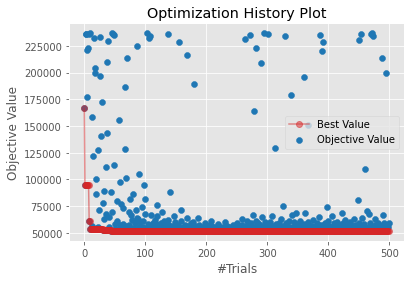

In [95]:
plot_optimization_history(study_200)